In [1]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import (
    Conv2D, Activation, BatchNormalization,
    UpSampling2D, Input, Concatenate,
    Conv2DTranspose
)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
#from models import unet_model

2024-02-20 20:49:06.006266: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 20:49:06.006333: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 20:49:06.008416: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-20 20:49:06.018554: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-20 20:49:08.331634: W tensorflow/compiler/tf2

In [2]:
tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices([], 'GPU')

2024-02-20 20:49:12.237011: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-20 20:49:12.334204: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-20 20:49:12.334691: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
tf.keras.backend.clear_session()

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

# Hyperparameters

In [5]:
IMAGE_SIZE = 256
EPOCHS = 10
BATCH_SIZE = 4
LR = 1e-4

PATH = "."

# Dataset

In [6]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))
    
    total_size = len(images)
    valid_size = int(total_size * split)
    test_size = int(total_size * split)
    
    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)
    
    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)
    
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [7]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x / 255.0
    
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x / 255.0
    x = np.expand_dims(x, axis=-1)
    
    return x

## Building the tf.data pipeline

In [8]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        
        return x, y
    
    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    
    return x, y


def tf_dataset(x, y, batch=BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    
    return dataset

In [9]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    
    return x

# Model

In [10]:
#inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
#encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)

In [11]:
#encoder.summary()

In [12]:
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
encoder2 = InceptionV3(input_tensor=inputs, weights="imagenet", include_top=False)

In [13]:
len(encoder2.layers)

311

In [15]:
#x = encoder2.get_layer("mixed10").output
#x = Conv2DTranspose(x.shape[3], (3, 3), strides=(1, 1), padding='valid') (x)
#x

activation_2 = Conv2DTranspose(x.shape[3], (4, 4), strides=(1, 1), padding='valid') (x)
activation_4 = Conv2DTranspose(x.shape[3], (5, 5), strides=(1, 1), padding='valid') (x)
mixed2 = Conv2DTranspose(x.shape[3], (4, 4), strides=(1, 1), padding='valid') (x)
mixed7 = Conv2DTranspose(x.shape[3], (3, 3), strides=(1, 1), padding='valid') (x)
mixed10 = Conv2DTranspose(x.shape[3], (3, 3), strides=(1, 1), padding='valid') (x)

In [16]:
#x = encoder2.get_layer("block13_sepconv2_act").output
#x = UpSampling2D((2, 2))(x)
#x

In [17]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")

    encoder = InceptionV3(input_tensor=inputs, weights="imagenet", include_top=False)
    # skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    # 6 -> 14 -> 29 -> 60/62 -> 125
    skip_connection_names = ["input_image", "activation_2", "activation_4", "mixed2", "mixed7"]
    fix_skip_kernel3 = ["mixed7", "mixed10"]
    fix_skip_kernel4 = ["activation_2", "mixed2"]
    fix_skip_kernel5 = ["activation_4"]
    encoder_output = encoder.get_layer("mixed10").output

    f = [16, 32, 48, 64, 80]
    x = encoder_output
    x = Conv2DTranspose(x.shape[3], (3, 3), strides=(1, 1), padding='valid') (x)
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        print("x_skip original: " + str(x_skip.shape))
        if skip_connection_names[-i] in fix_skip_kernel3:
            x_skip = Conv2DTranspose(x_skip.shape[3], (3, 3), strides=(1, 1), padding='valid') (x_skip)
        elif skip_connection_names[-i] in fix_skip_kernel4:
            x_skip = Conv2DTranspose(x_skip.shape[3], (4, 4), strides=(1, 1), padding='valid') (x_skip)
        elif skip_connection_names[-i] in fix_skip_kernel5:
            x_skip = Conv2DTranspose(x_skip.shape[3], (5, 5), strides=(1, 1), padding='valid') (x_skip)
        print("x original" + str(x.shape))
        x = UpSampling2D((2, 2))(x)
        print("x upsampling: " + str(x.shape))
        print("x_skip convolved: " + str(x_skip.shape))
        print("---------")
        x = Concatenate()([x, x_skip])

        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs, x)
    return model

In [18]:
model = model()
model.summary()

x_skip original: (None, 14, 14, 768)
x original(None, 8, 8, 2048)
x upsampling: (None, 16, 16, 2048)
x_skip convolved: (None, 16, 16, 768)
---------
x_skip original: (None, 29, 29, 288)
x original(None, 16, 16, 80)
x upsampling: (None, 32, 32, 80)
x_skip convolved: (None, 32, 32, 288)
---------
x_skip original: (None, 60, 60, 192)
x original(None, 32, 32, 64)
x upsampling: (None, 64, 64, 64)
x_skip convolved: (None, 64, 64, 192)
---------
x_skip original: (None, 125, 125, 64)
x original(None, 64, 64, 48)
x upsampling: (None, 128, 128, 48)
x_skip convolved: (None, 128, 128, 64)
---------
x_skip original: (None, 256, 256, 3)
x original(None, 128, 128, 32)
x upsampling: (None, 256, 256, 32)
x_skip convolved: (None, 256, 256, 3)
---------
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 256, 

# Metrics

In [19]:
smooth = 1e-15

def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# Training

In [20]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH_SIZE)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH_SIZE)

In [21]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [22]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

In [23]:
train_steps = len(train_x) // BATCH_SIZE
valid_steps = len(valid_x) // BATCH_SIZE

if len(train_x) % BATCH_SIZE != 0:
    train_steps += 1
if len(valid_x) % BATCH_SIZE != 0:
    valid_steps += 1
    
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/10


2024-02-13 18:30:55.778602: I external/local_xla/xla/service/service.cc:168] XLA service 0x1473a380 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-02-13 18:30:55.778841: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-02-13 18:30:55.803770: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1707859855.879390   29640 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-02-13 18:30:55.880835: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


66/66 [==============================] - 448s 6s/step - loss: 0.9272 - dice_coef: 0.0728 - val_loss: 0.9524 - val_dice_coef: 0.0439 - lr: 1.0000e-04
Epoch 2/10
66/66 [==============================] - 359s 5s/step - loss: 0.8996 - dice_coef: 0.1004 - val_loss: 0.9313 - val_dice_coef: 0.0632 - lr: 1.0000e-04
Epoch 3/10
66/66 [==============================] - 358s 5s/step - loss: 0.8843 - dice_coef: 0.1157 - val_loss: 0.9085 - val_dice_coef: 0.0842 - lr: 1.0000e-04
Epoch 4/10
66/66 [==============================] - 402s 6s/step - loss: 0.8748 - dice_coef: 0.1252 - val_loss: 0.8915 - val_dice_coef: 0.0998 - lr: 1.0000e-04
Epoch 5/10
66/66 [==============================] - 391s 6s/step - loss: 0.8658 - dice_coef: 0.1342 - val_loss: 0.8923 - val_dice_coef: 0.0990 - lr: 1.0000e-04
Epoch 6/10
66/66 [==============================] - 396s 6s/step - loss: 0.8566 - dice_coef: 0.1434 - val_loss: 0.8504 - val_dice_coef: 0.1382 - lr: 1.0000e-04
Epoch 7/10
66/66 [==============================] -

In [24]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH_SIZE)

test_steps = len(test_x) // BATCH_SIZE
if len(test_x) % BATCH_SIZE != 0:
    test_steps += 1
    
model.evaluate(test_dataset, steps=test_steps)

9/9 [==============================] - 12s 1s/step - loss: 0.8118 - dice_coef: 0.1725


[0.8118398189544678, 0.17248018085956573]

# Results

In [25]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [26]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

1/1 [==============================] - 0s 348ms/step


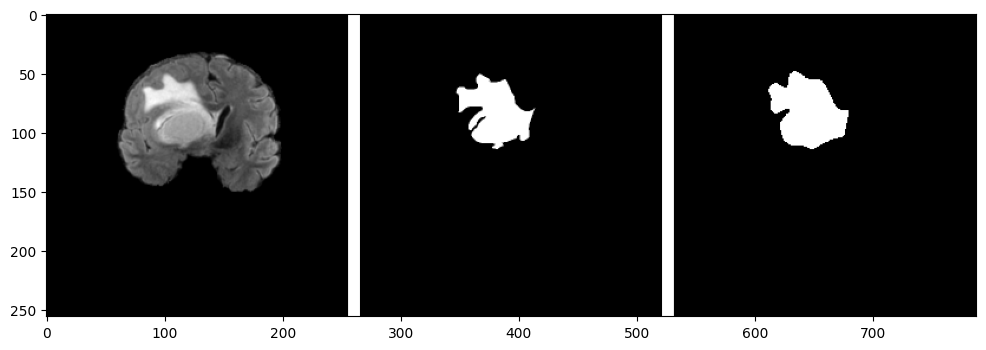

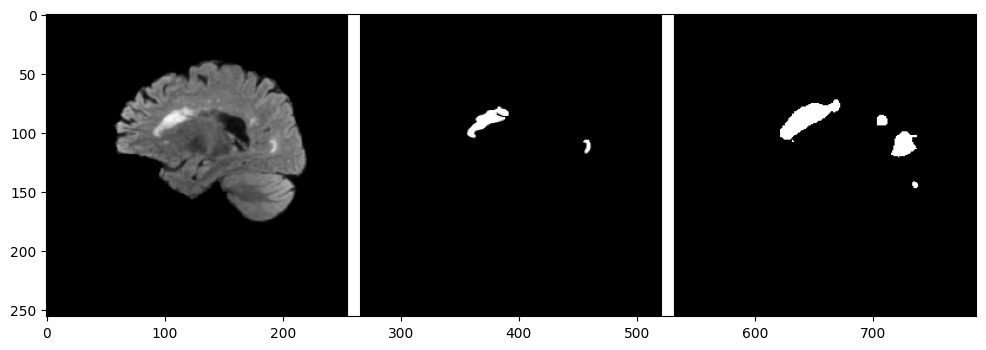

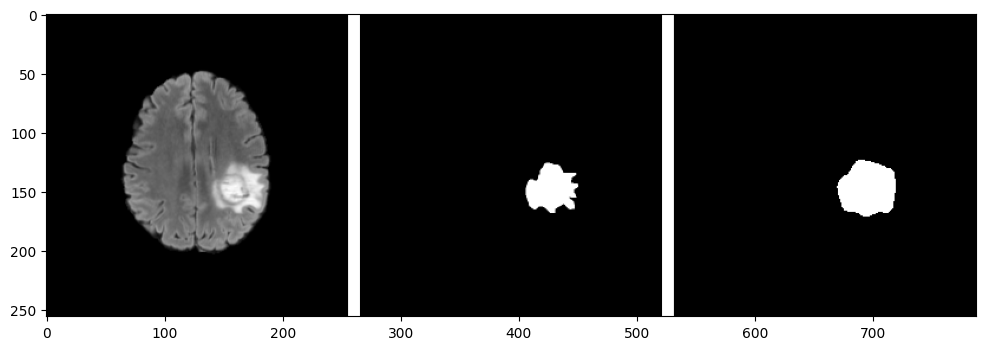

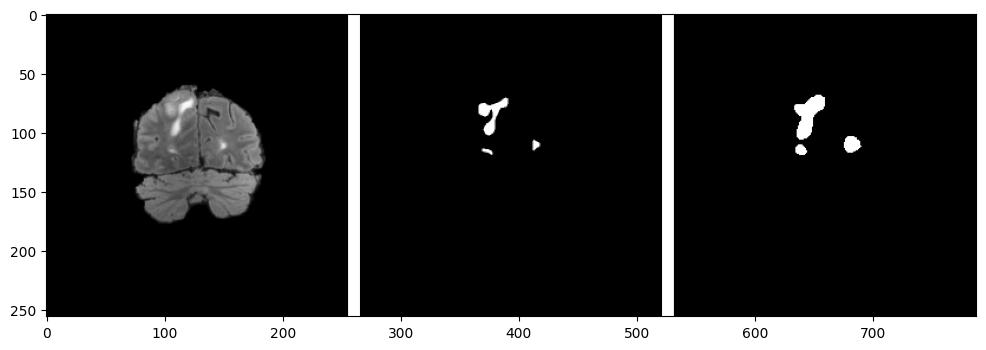

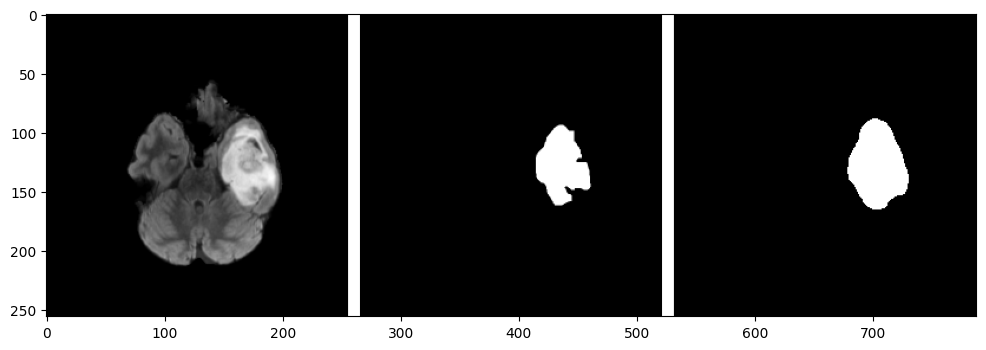

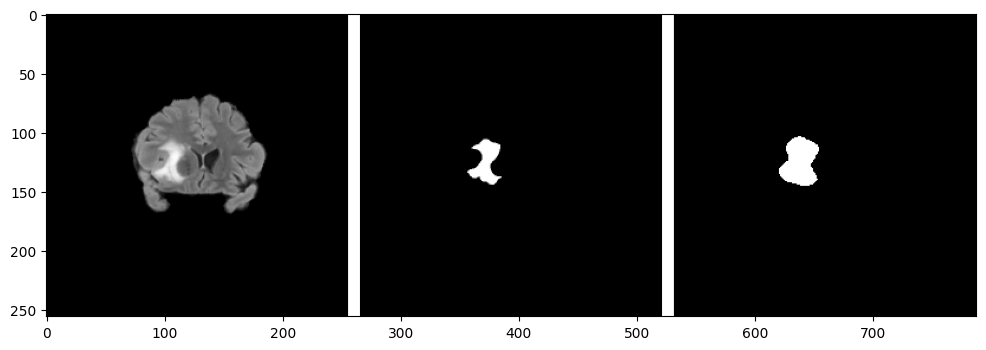

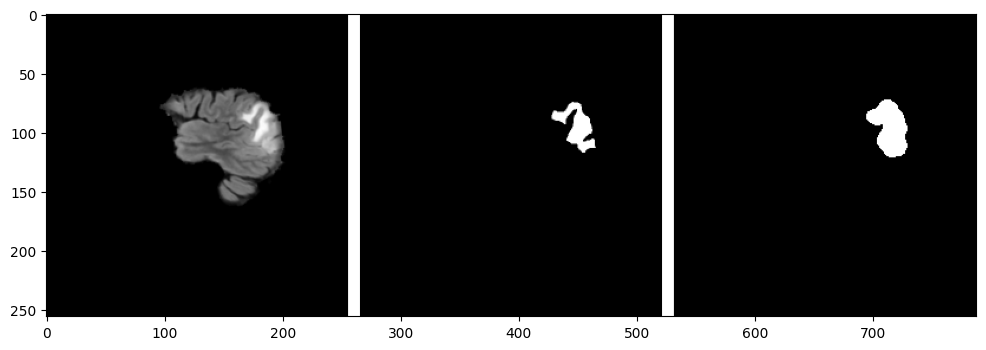

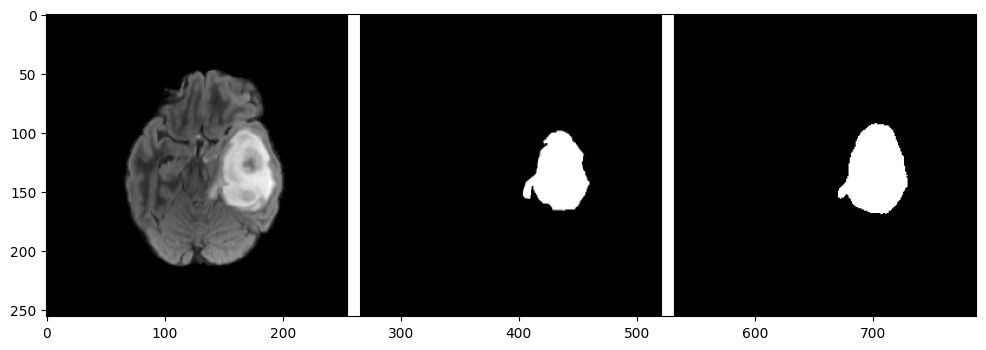

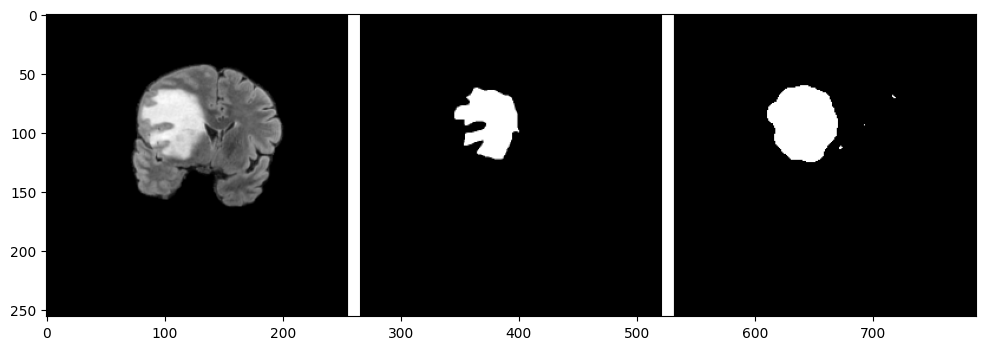

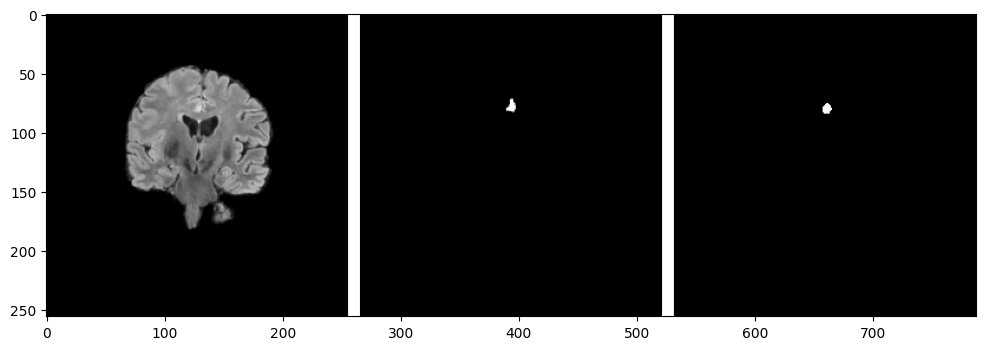

In [27]:
for i, (x, y) in enumerate(zip(test_x[:10], test_y[:10])):
    x = read_image(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)

    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)